In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt
import collections
import upsetplot
from Levenshtein import distance

import analysis_functions as af

In [2]:
# config filename:

# Cellranger output
cr_whitelist = "../data/scmixology/cellranger/whitelist.tsv"


# BLAZE output
blaze_raw_bc_fn = '../data/scmixology/blaze/raw_bc.csv'

# sockeye
sock_whitelist = '../data/scmixology/sockeye/sockeye_whitelist.tsv'
sock_count = '../data/scmixology/sockeye/uncorrected_bc_counts.tsv'

## Cellranger metrics

In [23]:
# this list was obtained from the emptydrops run.
cr_empty = {
"TTACAGGTCGCACGGT",
"ATGGAGGGTGTCCAAT",
"CGTGATAGTTCCCAAA",
"AATCGACGTATCATGC",
"ACGGGTCCACTTCAGA",
"GAGTCATTCTTCGATT",
"GGTTCTCCAGGTGACA",
"TCGATTTTCAACCTCC",
"CCGCAAGTCGAGCCTG",
"TGTCCTGAGCGTACAG",
"GTTAGTGAGCCTCTTC",
"AGTGATCGTTCGATTG",
"CACTGGGGTATTCTCT",
"AACCTGACACGTGTGC",
"CGTAATGAGCGTCTGC",
"AGGGCCTTCAAGGTGG",
"ATCCACCTCACTGCTC",
"TCATTTGTCGACCACG",
"TCACATTGTGCAGATG",
"ACATTTCTCAAGGACG"}

In [4]:
cr_filtered_bc = []
with open(cr_whitelist, 'r') as f:
    for i in f:
        cr_filtered_bc.append(i.split('-')[0].strip())
cr_filtered_bc = set(cr_filtered_bc)


## BLAZE

In [5]:
# blaze raw bc table
raw_bc_d = pd.read_csv(blaze_raw_bc_fn)

### 10X BC (ground true)

In [6]:
whole_whitelist = []
with open("../data/3M-february-2018.txt", 'r') as f:
    for line in f:
        whole_whitelist.append(line.strip())
whole_whitelist = set(whole_whitelist)

### Thresholding strategy

####  Default threshod of minQ: 15

In [7]:
# threshold for minQ
def tune_minQ(minQ, d):
    raw_bc_d_HQ = d[d.raw_bc_min_q >= minQ].raw_bc.value_counts().to_frame()
    raw_bc_d_HQ['bc_rank'] = list(range(1,len(raw_bc_d_HQ)+1))
    raw_bc_d_HQ.reset_index(inplace=True)
    raw_bc_d_HQ = raw_bc_d_HQ.rename(columns = {'index':'BC', 'raw_bc':'counts'})
    rst_d = raw_bc_d_HQ[raw_bc_d_HQ.BC.isin(whole_whitelist)]
    rst_d.reset_index(inplace=True)
    print(rst_d.counts.sum())
    return rst_d

# use default threshold 15 
raw_bc_d_minQ15_filtered = tune_minQ(15, d = raw_bc_d)

8125333


#### Default threshod of count Quantile (95-percentile of top N cell / 20)

In [8]:
# 99-percentile of top N cell / 10
def percentile_count_thres(count_array, exp_cells=None):
    if exp_cells:
        top_count = np.sort(count_array)[::-1][:exp_cells]
        return np.quantile(top_count, 0.95)/20
    else:
        exp_cells = 0
        new_exp_cells = int(len(count_array)/2)
        count_array = np.sort(count_array)[::-1]
        while exp_cells != new_exp_cells:  
            exp_cells = new_exp_cells
            
            top_count = count_array[:exp_cells]
            t = np.quantile(top_count, 0.95)/20

            new_exp_cells = (count_array >= t).sum()
            print(exp_cells,new_exp_cells, t)
        return t

threshold = percentile_count_thres(raw_bc_d_minQ15_filtered.counts,500)

In [9]:
# 95-percentile of top N cell / 200
def percentile_count_thres_high_sensitivity(count_array, exp_cells=None):
    if exp_cells:
        top_count = np.sort(count_array)[::-1][:exp_cells]
        return np.quantile(top_count, 0.95)/200
    else:
        exp_cells = 0
        new_exp_cells = int(len(count_array)/2)
        count_array = np.sort(count_array)[::-1]
        while exp_cells != new_exp_cells:  
            exp_cells = new_exp_cells
            
            top_count = count_array[:exp_cells]
            t = np.quantile(top_count, 0.95)/200

            new_exp_cells = (count_array >= t).sum()
            print(exp_cells,new_exp_cells, t)
        return t

threshold_high_sen = percentile_count_thres_high_sensitivity(raw_bc_d_minQ15_filtered.counts,500)

#### Number of barcode vs Expected number of cells

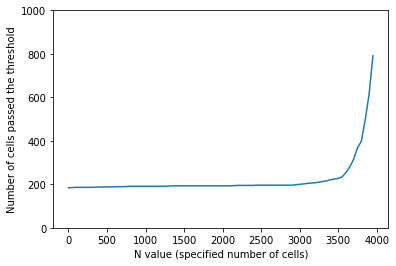

In [10]:
x = np.arange(1,4000,50)
y = [sum(raw_bc_d_minQ15_filtered.counts >= percentile_count_thres(raw_bc_d_minQ15_filtered.counts,i)) for i in x ]
plt.plot(x,y)
plt.xlabel("N value (specified number of cells)")
plt.ylabel("Number of cells passed the threshold")
plt.ylim(0,1000)
# plt.savefig('tuneN_scm.svg', format='svg')
plt.show()

### BLAZE accuracy (compared to Cellranger whitelist)

In [11]:
def remove_similar_bc(good_list, list_to_check, max_ed=2):
    """
    check the edit distance (ED) of each BC in `list_to_check` and each BC in `good_list`. remove BC in list_to_check
    if any close match (ED<=max_ed) was found . 
    """
    good_list = list(good_list)
    list_to_check = list(list_to_check)
    list_to_keep = []
    for i in tqdm(list_to_check):
        if min([distance(i,x) for x in good_list]) > max_ed:
             list_to_keep.append(i)  
    return set(good_list + list_to_keep)


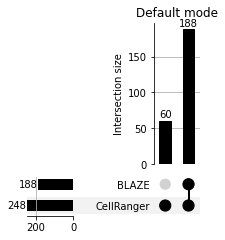

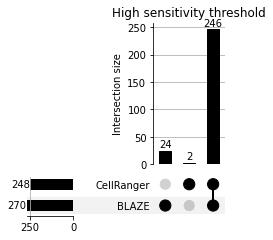

In [70]:
# Agreement BLAZE and cellranger
from upsetplot import from_contents
bc_pass_idx = raw_bc_d_minQ15_filtered.counts >= threshold
passed_bc = set(raw_bc_d_minQ15_filtered[bc_pass_idx].BC)
a = from_contents({'BLAZE':passed_bc, 'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.title('Default mode')
plt.show()

# high sensitivity threshold
bc_pass_idx_hs = raw_bc_d_minQ15_filtered.counts >= threshold_high_sen
passed_bc_hs = set(raw_bc_d_minQ15_filtered[bc_pass_idx_hs].BC)
a = from_contents({'BLAZE':passed_bc_hs, 'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.title('High sensitivity threshold')
plt.show()

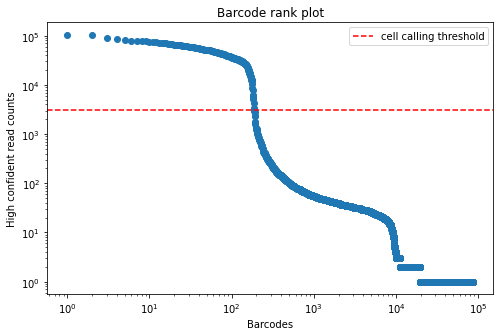

In [13]:
# Barcode rank plot
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.loglog(list(raw_bc_d_minQ15_filtered.counts), marker="o", linestyle="")

ax.set_xlabel('Barcodes')
ax.set_ylabel('High confident read counts')
ax.set_title('Barcode rank plot')
ax.axhline(y=threshold, color='r', linestyle='--', label = 'cell calling threshold')
ax.legend()

fig.show()

## Sockeye

### Loading sockeye whitelist and check the agreement

In [14]:
# load sockeye whitelist
sock_whitelist = set(pd.read_csv(sock_whitelist, header = None)[0])

# sockeye raw count
sock_count = pd.read_csv(sock_count, header = None, sep = '\t', names = ['BC', 'counts'])

# sort the count
sock_count = sock_count.sort_values(by=['counts'], ascending = False)

### Overlap BLAZE x Sockeye x Cellranger

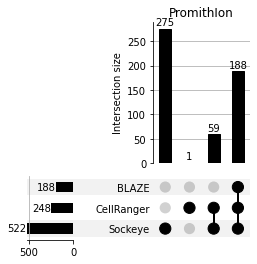

In [15]:
# BLAZE in default mode
from upsetplot import from_contents

a = from_contents({'BLAZE':passed_bc, 
                   'Sockeye':sock_whitelist, 
                   'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.title("PromithIon")
# plt.savefig('upset_scm.svg', format= 'svg')
plt.show()


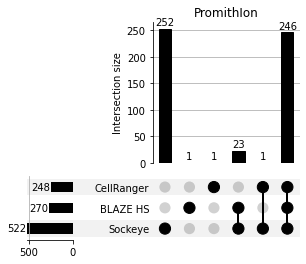

In [71]:
# BLAZE in High Sensitivity mode
bc_pass_idx_high_sen = raw_bc_d_minQ15_filtered.counts >= threshold_high_sen
passed_bc_high_sen = set(raw_bc_d_minQ15_filtered[bc_pass_idx_high_sen].BC)
# upset plot
from upsetplot import from_contents

a = from_contents({'BLAZE HS':passed_bc_high_sen, 
                   'Sockeye':sock_whitelist, 
                   'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.title("PromithIon")
plt.show()

I plot the following three categories:
* Cat1: Found by Sockeye only
* Cat2: Found by CellRanger only
* Cat3: Found by Sockeye and CellRanger but not BLAZE
* Cat4: Found by all of three methods

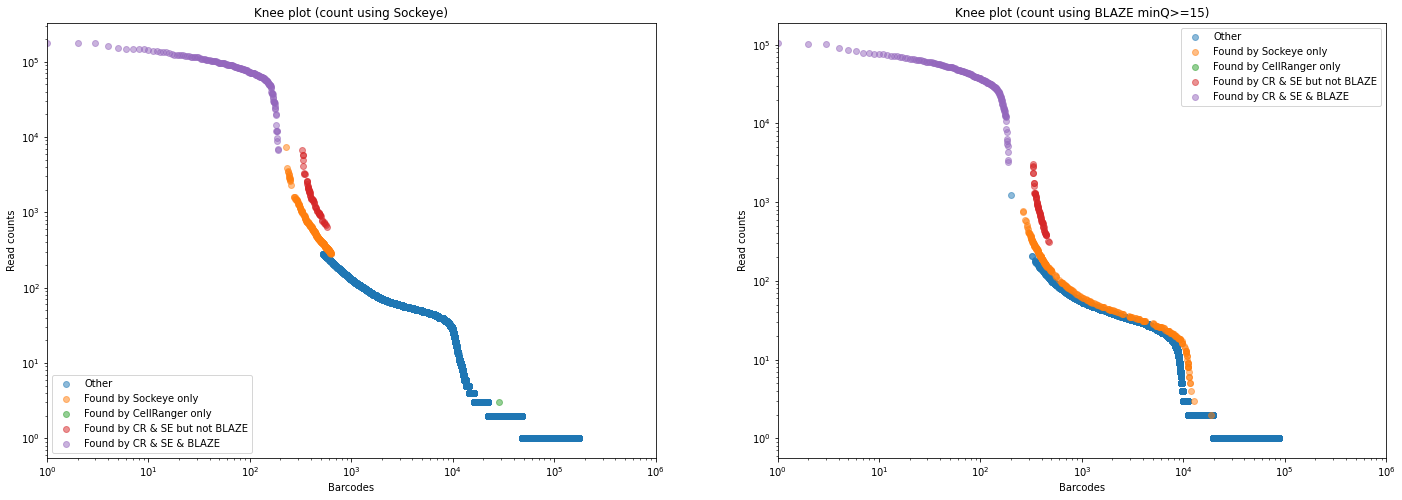

In [72]:
# 4 categories of cells on  range plot from three methods
cat1 = sock_whitelist-cr_filtered_bc-passed_bc
cat2 = cr_filtered_bc-sock_whitelist-passed_bc
cat3 = (cr_filtered_bc &  sock_whitelist) - passed_bc
cat4= (cr_filtered_bc &  sock_whitelist & passed_bc)
# One CellRanger Knee plot
fig, ( ax2, ax3) = plt.subplots(1, 2, figsize=(24, 8))



ax2.set_title('Knee plot (count using Sockeye)')
ax2.loglog(sock_count[~sock_count.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
           sock_count[~sock_count.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat1)].index+1)*1.2,
           sock_count[sock_count.BC.isin(cat1)].counts,
           marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat2)].index+1)*1.2**2,
           sock_count[sock_count.BC.isin(cat2)].counts,
           marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat3)].index+1)*1.2**3,
           sock_count[sock_count.BC.isin(cat3)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat4)].index+1),
           sock_count[sock_count.BC.isin(cat4)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
#ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax2.legend(loc = 'lower left')
ax2.set_xlabel('Barcodes')
ax2.set_ylabel('Read counts')
ax2.set_xlim(1,1000000)


ax3.set_title('Knee plot (count using BLAZE minQ>=15)')
ax3.loglog(raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
           raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat1)].index+1)*1.2,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat1)].counts,
           marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat2)].index+1)*1.2**2,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat2)].counts,
           marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat3)].index+1)*1.2**3,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat3)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat4)].index+1),
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat4)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
#ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax3.legend()
ax3.set_xlabel('Barcodes')
ax3.set_ylabel('Read counts')
ax3.set_xlim(1,1000000)


fig.show()


## Check wether sockeye-specific BCs are pecicularly similar to CR

In [20]:
from Levenshtein import distance
sock_only = sock_whitelist - passed_bc - cr_filtered_bc
sock_only_list = list(sock_only)
min_ed_list = []

for i in tqdm(sock_only):
    min_ed_list.append(min([distance(i,x) for x in cr_filtered_bc]))
sock_only_bc = pd.DataFrame({
    'BC':sock_only_list,
    'ED': min_ed_list
})


s = sock_only_bc.ED.value_counts().sort_index()

100%|███████████████████████████████████████| 275/275 [00:00<00:00, 7276.08it/s]


## PRC plot

In [24]:
from sklearn.metrics import precision_recall_curve

#calculate precision and recall
# add count 0 for true BC if not exsit in the df
# ground true 
true_bc = cr_filtered_bc - cr_empty
# blaze


missing_bc =  [1]* len(true_bc - set(raw_bc_d_minQ15_filtered.BC))
missing_bc_count = [0] * len(missing_bc)
blaze_pre,blaze_recall , blaze_thresholds =\
                            precision_recall_curve([int(x in true_bc) for x in raw_bc_d_minQ15_filtered.BC] + missing_bc,
                                                   list(raw_bc_d_minQ15_filtered.counts) + missing_bc_count)

missing_bc =  [1]* len(true_bc - set(sock_count.BC))
missing_bc = [1] * len(missing_bc)
missing_bc_count = [0] * len(missing_bc)
sockeye_pre,sockeye_recall , sockeye_thresholds =\
                            precision_recall_curve([int(x in true_bc) for x in sock_count.BC] + missing_bc,
                                                   list(sock_count.counts)+missing_bc_count)


/tmp/ipykernel_23741/1921834585.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([blz_re], [blz_p],'o',  color='c',markersize=6, label='BLAZE default threshold', marker = 'x' )
/tmp/ipykernel_23741/1921834585.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([sock_re], [sock_p],'o',   color='orange',markersize=6, label='Sockeye default threshold', marker = 'x' )
/tmp/ipykernel_23741/1921834585.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([blz_hi_re], [blz_hi_p], 'o', color='c', markersize=6, label='BLAZE HS mode' , marker = '^' )


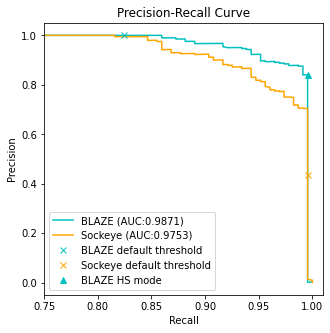

In [66]:
from sklearn.metrics import auc
#create precision recall curve

sock_p  = len(true_bc&sock_whitelist)/len(sock_whitelist)
sock_re = len(true_bc&sock_whitelist)/len(true_bc)
blz_p = len(true_bc&passed_bc)/len(passed_bc)
blz_re = len(true_bc&passed_bc)/len(true_bc)
blz_hi_p = len(true_bc&passed_bc_high_sen)/len(passed_bc_high_sen)
blz_hi_re = len(true_bc&passed_bc_high_sen)/len(true_bc)


fig, ax = plt.subplots(figsize = (5,5))
ax.plot(blaze_recall, blaze_pre, 
        label = f'BLAZE (AUC:{auc(blaze_recall,blaze_pre):.4f})', color='c')

ax.plot(sockeye_recall, sockeye_pre, 
        label = f'Sockeye (AUC:{auc(sockeye_recall, sockeye_pre):.4f})', color='orange')


ax.plot([blz_re], [blz_p],'o',  color='c',markersize=6, label='BLAZE default threshold', marker = 'x' )
ax.plot([sock_re], [sock_p],'o',   color='orange',markersize=6, label='Sockeye default threshold', marker = 'x' )
ax.plot([blz_hi_re], [blz_hi_p], 'o', color='c', markersize=6, label='BLAZE HS mode' , marker = '^' )
ax.legend()
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_xlim(0.75,1.01)
#ax.set_ylim(0,1.01)


#display plot
plt.savefig('scmix_prc_zoomin.svg', format='svg')
plt.show()